<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

import re
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.18.5


In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):   
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [6]:
VERSION    = 16
DIR_TRAIN  = './datas/' # подключил к ноутбуку внешний датасет

DIR_TEST   = './datas/'
VAL_SIZE   = 0.30   # 30%

# Data

In [8]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv') # датасет для обучения модели
train2 = pd.read_csv(DIR_TRAIN+'all_auto_ru_14_11_2020.csv') # датасет для обучения модели
train3 = pd.read_csv(DIR_TRAIN+'_auto_ru_2006-2010.csv') # датасет для обучения модели

test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [9]:
train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [10]:
train2.head()

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,...,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,price_EUR,price_USD
0,Седан,AUDI,97948F,{'id': '0'},Машина на полном ходу\nСостояние хорошее\nС до...,2.3,133.0,{},бензин,5,...,3.0,NaN,ORIGINAL,передний,LEFT,True,True,106000.0,1161.0,1371.0
1,Седан,AUDI,CACECB,{'id': '0'},Продажа от официального дилера KIA - Компания ...,1.8,90.0,"{'condition': True, 'audiosystem-cd': True, 'f...",бензин,7,...,3.0,NaN,ORIGINAL,передний,LEFT,True,True,44000.0,482.0,569.0
2,Седан,AUDI,040001,{'id': '0'},Автомобиль продает Официальный дилер Hyundai. ...,2.6,150.0,"{'airbag-driver': True, 'isofix': True, 'elect...",бензин,11,...,3.0,NaN,DUPLICATE,передний,LEFT,True,True,167000.0,1829.0,2160.0
3,Седан,AUDI,DEA522,{'id': '0'},Продам машину в нормальном состоянии не гнилая...,2.0,101.0,{},бензин,7,...,3.0,NaN,DUPLICATE,передний,LEFT,True,True,135000.0,1478.0,1746.0
4,Седан,AUDI,0000CC,{'id': '0'},Комплектация:\n• Антиблокировочная система\n• ...,2.3,133.0,"{'alloy-wheel-disks': True, 'abs': True, 'whee...",бензин,15,...,2.0,NaN,ORIGINAL,передний,LEFT,True,True,130000.0,1424.0,1681.0


In [11]:
train3.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,Таможня,Владение
0,хэтчбек 5 дв.,FORD,https://auto.ru/cars/used/sale/ford/focus/1101...,чёрный,"{""id"":""20189931"",""name"":""Trend"",""available_opt...",Продам верного помощника. Автомобиль с 2006 го...,1.8 LTR,125 N12,"{""steel-wheels"":true,""ptf"":true,""airbag-driver...",бензин,...,HATCHBACK_5_DOORS MECHANICAL 1.8,механическая,AMERICAN,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN
1,седан,MITSUBISHI,https://auto.ru/cars/used/sale/mitsubishi/lanc...,серебристый,"{""id"":""0""}",Я второй владелец по ПТС с 2010 года. Автомоби...,1.6 LTR,98 N12,"{""usb"":true,""lock"":true,""audiosystem-tv"":true,...",бензин,...,SEDAN MECHANICAL 1.6,механическая,JAPANESE,2 владельца,Оригинал,передний,Левый,Не требует ремонта,Растаможен,10 лет и 1 месяц
2,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc90/1101...,коричневый,"{""id"":""0""}",Авто беpежноe xрaнeниe.\nКоробка переключается...,2.5 LTR,210 N12,"{""engine-proof"":true,""cruise-control"":true,""ti...",бензин,...,ALLROAD_5_DOORS AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,Оригинал,полный,Левый,Не требует ремонта,Растаможен,NaN
3,седан,HYUNDAI,https://auto.ru/cars/used/sale/hyundai/sonata/...,чёрный,"{""id"":""0""}",Учетный № 5064107\n\nМесто осмотра автомобиля ...,2.4 LTR,161 N12,"{""ptf"":true,""esp"":true,""airbag-side"":true,""mir...",бензин,...,SEDAN AUTOMATIC 2.4,автоматическая,KOREAN,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN
4,универсал 5 дв.,PEUGEOT,https://auto.ru/cars/used/sale/peugeot/407/110...,чёрный,"{""id"":""0""}",Автомобиль проверен и готов к эксплуатации!\n-...,2.0 LTR,140 N12,"{""condition"":true,""ptf"":true,""abs"":true,""airba...",бензин,...,WAGON_5_DOORS MECHANICAL 2.0,механическая,EUROPEAN,3 или более,Оригинал,передний,Левый,Не требует ремонта,Растаможен,NaN


In [12]:
train2.shape

(77449, 34)

In [13]:
train3.shape

(14647, 32)

In [14]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [15]:
train = pd.concat([train, train2,train3])

In [16]:
train.head()

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,model_info,model_name,priceCurrency,sell_id,super_gen,vendor,price_EUR,price_USD,car_url,parsing_unixtime
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991.0,SEDAN MECHANICAL 2.8,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986.0,SEDAN MECHANICAL 1.8,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989.0,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989.0,SEDAN MECHANICAL 1.8,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991.0,SEDAN MECHANICAL 2.0,MECHANICAL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
train = train.drop_duplicates()

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177817 entries, 0 to 14646
Data columns (total 39 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              177812 non-null  object 
 1   brand                 177815 non-null  object 
 2   color                 177815 non-null  object 
 3   fuelType              177814 non-null  object 
 4   modelDate             177812 non-null  float64
 5   name                  177812 non-null  object 
 6   numberOfDoors         177812 non-null  float64
 7   productionDate        177815 non-null  float64
 8   vehicleConfiguration  177812 non-null  object 
 9   vehicleTransmission   177811 non-null  object 
 10  engineDisplacement    177814 non-null  object 
 11  enginePower           177812 non-null  object 
 12  description           171959 non-null  object 
 13  mileage               175970 non-null  float64
 14  Комплектация          87264 non-null   object 
 15  П

In [19]:
test.head(5)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [21]:
df_train = train.copy()
df_test = test.copy()
df_test['price'] = 0

In [22]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

In [23]:
data = df_test.append(df_train, sort=False) # объединяем

## Data Preprocessing

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212503 entries, 0 to 14646
Data columns (total 40 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              212498 non-null  object 
 1   brand                 212501 non-null  object 
 2   car_url               49296 non-null   object 
 3   color                 212501 non-null  object 
 4   complectation_dict    96969 non-null   object 
 5   description           206645 non-null  object 
 6   engineDisplacement    212500 non-null  object 
 7   enginePower           212498 non-null  object 
 8   equipment_dict        115241 non-null  object 
 9   fuelType              212500 non-null  object 
 10  image                 110629 non-null  object 
 11  mileage               210656 non-null  float64
 12  modelDate             212498 non-null  float64
 13  model_info            125237 non-null  object 
 14  model_name            125237 non-null  object 
 15  n

In [25]:
data.corr()

,mileage,modelDate,numberOfDoors,parsing_unixtime,productionDate,sell_id,price,sample,hidden,price_EUR,price_USD
mileage,1.000000,-0.691436,-0.099360,0.062504,-0.726545,-0.048477,-0.439887,-0.100897,NaN,-0.489995,-0.489995
modelDate,-0.691436,1.000000,0.187431,-0.148805,0.961874,0.072803,0.418741,0.073133,NaN,0.466775,0.466776
numberOfDoors,-0.099360,0.187431,1.000000,0.012568,0.196749,0.029488,0.074546,0.036906,NaN,0.099599,0.099599
parsing_unixtime,0.062504,-0.148805,0.012568,1.000000,-0.097852,0.010711,0.361950,0.999137,NaN,NaN,NaN
productionDate,-0.726545,0.961874,0.196749,-0.097852,1.000000,0.073923,0.427659,0.086078,NaN,0.470953,0.470954
sell_id,-0.048477,0.072803,0.029488,0.010711,0.073923,1.000000,0.041485,0.039571,NaN,0.091880,0.091881
price,-0.439887,0.418741,0.074546,0.361950,0.427659,0.041485,1.000000,0.250475,NaN,1.000000,1.000000
sample,-0.100897,0.073133,0.036906,0.999137,0.086078,0.039571,0.250475,1.000000,NaN,NaN,NaN
hidden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price_EUR,-0.489995,0.466775,0.099599,NaN,0.470953,0.091880,1.000000,NaN,NaN,1.000000,1.000000


нам не потребуются:
'hidden' - неизвестная пустая строка,

'car_url' - ссылка на объявление,

'image' - фото авто, 

'sell_id' - id объявления,

'modelDate' - время появления модели, т.к. есть время производства авто,

'Таможня' - все авто растоможены,

'Состояние' - все авто не требуют ремонта,

'model_info' - расшифровка нас не интересует, а ходовые качества указаны в других полях,

'price_EUR' и 'price_USD' - нас интересуют цены только в рублях

'complectation_dict' - недостаточно времени для обработки

'description' - недостаточно времени для обработки

'equipment_dict' - недостаточно времени для обработки

'priceCurrency' - единственное значение - RUB

'super_gen' - 
'vehicleConfiguration', 'name' - информация повторяется в других колонках


In [26]:
data = data.drop(['hidden', 'car_url','image', 'sell_id','modelDate', 'price_EUR', 'price_USD',
                  'Таможня', 'Состояние', 'model_info','parsing_unixtime', 'complectation_dict','description', 'equipment_dict',
                  'priceCurrency','super_gen','Комплектация','start_date','Владение','vehicleConfiguration','name'],axis = 1)

In [27]:
for i in data.columns:
    print(i, len(data[i].value_counts()))

bodyType 206
brand 77
color 32
engineDisplacement 606
enginePower 763
fuelType 7
mileage 36257
model_name 1184
numberOfDoors 5
productionDate 83
vehicleTransmission 8
vendor 7
Владельцы 8
ПТС 4
Привод 3
Руль 4
price 14416
sample 2
model 1086


In [28]:
for i in data.columns:
    print(i, len(data[data[i].isna()]))

bodyType 5
brand 2
color 2
engineDisplacement 3
enginePower 5
fuelType 3
mileage 1847
model_name 87266
numberOfDoors 5
productionDate 2
vehicleTransmission 6
vendor 87267
Владельцы 27714
ПТС 811
Привод 6
Руль 2
price 719
sample 0
model 125239


упростим bodyType до базовых типов

In [29]:
data['bodyType'] = data['bodyType'].apply(lambda x: str(x).lower())
data['bodyType'] = data['bodyType'].apply(lambda x: re.findall(r'\w+', x)[0])

In [30]:
data = data[data['bodyType'] !='nan']

In [31]:
data['bodyType'].value_counts()

внедорожник    78006
седан          74376
хэтчбек        25417
лифтбек         8776
универсал       8322
минивэн         5974
компактвэн      4829
купе            4007
пикап           1491
кабриолет        451
родстер          405
фургон           349
микровэн          55
лимузин           20
тарга             14
фастбек            6
Name: bodyType, dtype: int64

In [32]:
other_cars = [ 'кабриолет', 'родстер', 'фургон','микровэн', 'лимузин', 'тарга', 'фастбек']
data['bodyType'] = data['bodyType'].apply(lambda x: 'другое' if x in other_cars else x )
data['bodyType'] = data['bodyType'].astype('category')

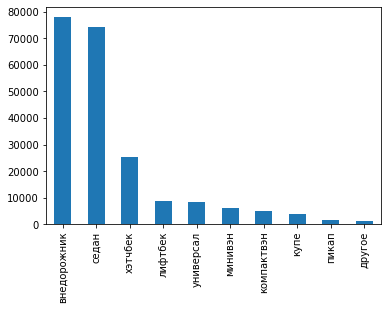

In [33]:
data['bodyType'].value_counts().plot(kind='bar')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


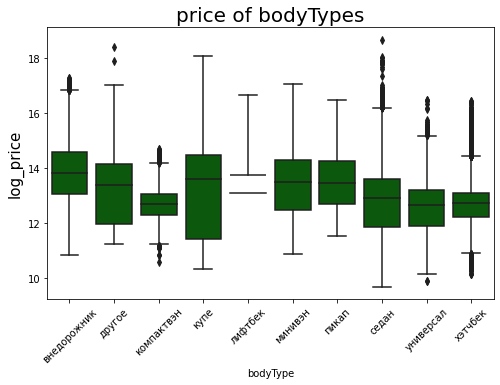

In [34]:
data['log_price'] = np.log(data.price)
plt.figure(figsize=(8, 5))
g1 = sns.boxplot(y='log_price', x='bodyType', 
                  data=data, color='darkgreen')
g1.set_title("price of bodyTypes", fontsize=20)

g1.set_ylabel("log_price", fontsize=15)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
plt.show()

In [35]:
data = data[data['numberOfDoors'].notna()]
data['numberOfDoors'] = data['numberOfDoors'].apply(lambda x: 2 if x == 0 else x)

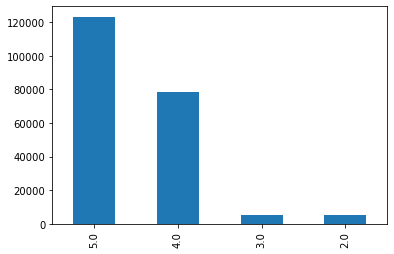

In [36]:
data['numberOfDoors'].value_counts().plot(kind='bar')

In [37]:
data['color'].value_counts()

040001         45643
FAFBFB         28630
97948F         20151
CACECB         19936
0000CC         16787
чёрный         15310
EE1D19          8683
белый           7217
200204          6620
серебристый     6470
серый           6029
синий           4807
007F00          4763
C49648          3531
красный         2614
22A0F8          2545
коричневый      1777
зелёный         1478
DEA522          1313
FFD600          1295
660099          1284
бежевый         1063
4A2197          1008
FF8649           970
голубой          788
золотистый       463
пурпурный        428
фиолетовый       333
жёлтый           274
оранжевый        230
FFC0CB            45
розовый           13
Name: color, dtype: int64

In [38]:
colors = {
'040001':   'черный',
'FAFBFB':          'белый',
'97948F':          'серый',
'CACECB':          'серебристый',
'0000CC':         'синий',
'EE1D19':         'красный',
'200204':  'бордовый',
'007F00':   'зелёный',
'C49648':   'коричневый',
'22A0F8':         'голубой',
'DEA522':         'золотистый',
'FFD600':          'жёлтый',
'660099':        'пурпурный',
'4A2197':          'фиолетовый',
'FF8649':        'бежевый',
'FFC0CB':  'розовый',
}

In [39]:
data['color'] = data['color'].replace(colors).apply(lambda x: x.lower())
data['color'] = data['color'].astype("category")

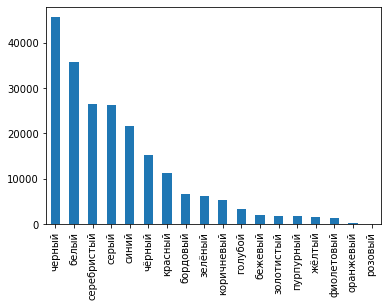

In [40]:
data['color'].value_counts().plot(kind='bar')

In [41]:
data = data[data['fuelType'].notna()]
data['fuelType'] = data['fuelType'].astype("category")

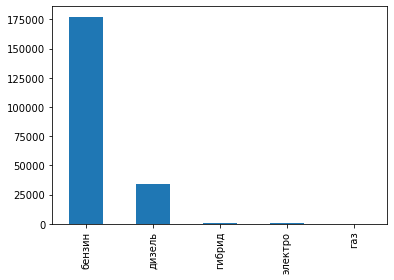

In [42]:
data['fuelType'].value_counts().plot(kind='bar')

In [43]:
data[data['mileage'].isna()]

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,productionDate,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price,sample,model,log_price
49,седан,HYUNDAI,серебристый,1.8 LTR,132 N12,бензин,NaN,ELANTRA,4.0,2006.0,автоматическая,KOREAN,3 или более,Оригинал,передний,Левый,340000.0,1,NaN,12.736701
262,минивэн,CHEVROLET,чёрный,5.3 LTR,294 N12,бензин,NaN,EXPRESS,5.0,2006.0,автоматическая,AMERICAN,3 или более,Оригинал,полный,Левый,1100000.0,1,NaN,13.910821
272,седан,NISSAN,белый,1.8 LTR,116 N12,бензин,NaN,PRIMERA,4.0,2006.0,механическая,JAPANESE,2 владельца,Оригинал,передний,Левый,220000.0,1,NaN,12.301383
281,седан,BMW,чёрный,2.5 LTR,218 N12,бензин,NaN,3ER,4.0,2006.0,автоматическая,EUROPEAN,3 или более,Оригинал,задний,Левый,400000.0,1,NaN,12.899220
282,хэтчбек,FORD,серый,1.8 LTR,125 N12,бензин,NaN,FOCUS,3.0,2006.0,механическая,AMERICAN,3 или более,Оригинал,передний,Левый,260000.0,1,NaN,12.468437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14615,внедорожник,UAZ,чёрный,2.7 LTR,112 N12,бензин,NaN,PATRIOT,5.0,2010.0,механическая,RUSSIAN,2 владельца,Оригинал,полный,Левый,400000.0,1,NaN,12.899220
14616,седан,DAEWOO,красный,1.6 LTR,109 N12,бензин,NaN,NEXIA,4.0,2010.0,механическая,RUSSIAN,2 владельца,Оригинал,передний,Левый,115000.0,1,NaN,11.652687
14625,седан,OPEL,серебристый,1.6 LTR,115 N12,бензин,NaN,ASTRA,4.0,2010.0,роботизированная,EUROPEAN,3 или более,Оригинал,передний,Левый,400000.0,1,NaN,12.899220
14626,седан,DAEWOO,красный,1.5 LTR,80 N12,бензин,NaN,NEXIA,4.0,2010.0,механическая,RUSSIAN,2 владельца,Оригинал,передний,Левый,147000.0,1,NaN,11.898188


In [44]:
data = data[data['mileage'].notna()]
data['mileage'] = data['mileage'].apply(lambda x: 1000 if x < 1000 else x)
data['mileage'].describe()

count     210652.000000
mean      138825.274078
std       102418.340216
min         1000.000000
25%        63586.500000
50%       133000.000000
75%       198000.000000
max      1000000.000000
Name: mileage, dtype: float64

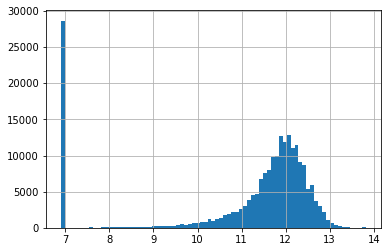

In [45]:
np.log(data['mileage']).hist(bins=77)

In [46]:
data['model_name'].value_counts()

OCTAVIA     2674
E_KLASSE    2648
FOCUS       2257
3ER         2084
5ER         2032
            ... 
ARRIZO7        1
DART           1
SAPPORO        1
MODEL_T        1
SAFRANE        1
Name: model_name, Length: 1178, dtype: int64

In [47]:
data['model_name'] = data['model_name'].fillna(data['model'])

In [48]:
data['model_name'].value_counts()

FOCUS       4721
OCTAVIA     4108
E_KLASSE    4036
5ER         3675
3ER         3439
            ... 
CX_3           1
SSR            1
924            1
IBIZA          1
MX_6           1
Name: model_name, Length: 1240, dtype: int64

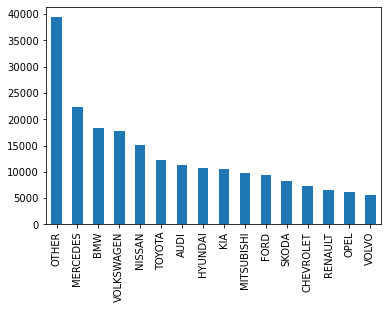

In [49]:
brand_list = list(data['brand'].value_counts()[:15].keys())
data['brand'] = data['brand'].apply(lambda x: x if x in brand_list else 'OTHER')
data['brand'] = data['brand'].astype('category')
data['brand'].value_counts().plot(kind='bar')


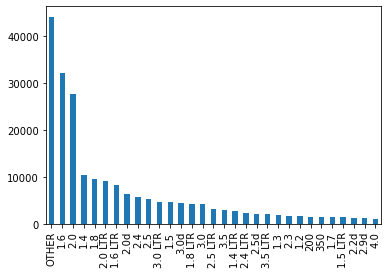

In [50]:
engine_list = list(data['engineDisplacement'].value_counts()[:30].keys())
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: x if x in engine_list else 'OTHER')
data['engineDisplacement'].value_counts().plot(kind='bar')

In [51]:
data['enginePower'].value_counts()

150.0      13536
249.0       7177
140.0       5094
105.0       4135
123.0       3899
           ...  
30 N12         1
45 N12         1
639 N12        1
35 N12         1
423 N12        1
Name: enginePower, Length: 759, dtype: int64

In [52]:
data['enginePower'] = data['enginePower'].apply(lambda x: int(re.findall('(\d+)', str(x))[0]))
data['enginePower']= data['enginePower'].astype('int')


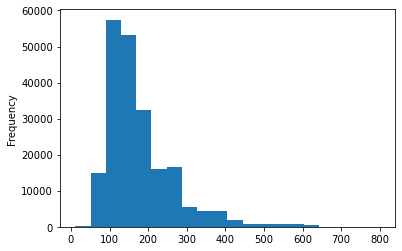

In [53]:
data['enginePower'].sort_values().plot.hist(bins=20)

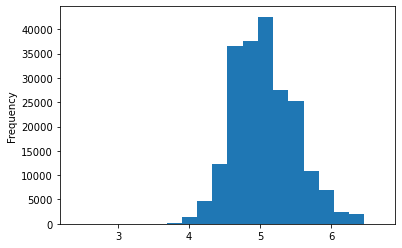

In [54]:
np.log(data['enginePower'].sort_values()).plot.hist(bins=20)

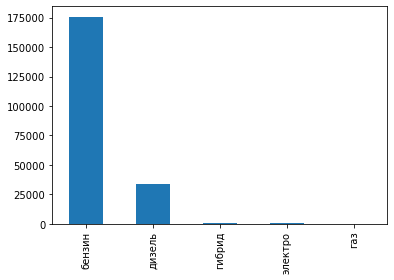

In [55]:
data['fuelType'] = data['fuelType'].astype('category')
data['fuelType'].value_counts().plot(kind='bar')

In [56]:
data['productionDate'].value_counts()

2020.0    26992
2008.0    17950
2007.0    14559
2012.0    14307
2011.0    13328
          ...  
1943.0        1
1966.0        1
1931.0        1
1928.0        1
1924.0        1
Name: productionDate, Length: 83, dtype: int64

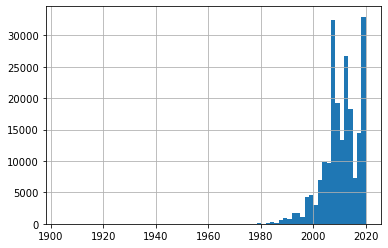

In [57]:
data['productionDate'].hist(bins=70)

In [58]:
vehicle = {'AUTOMATIC':'автоматическая',
'MECHANICAL':'механическая',
'ROBOT':'роботизированная',
'VARIATOR':'вариатор'}
data['vehicleTransmission'] = data['vehicleTransmission'].replace(vehicle)

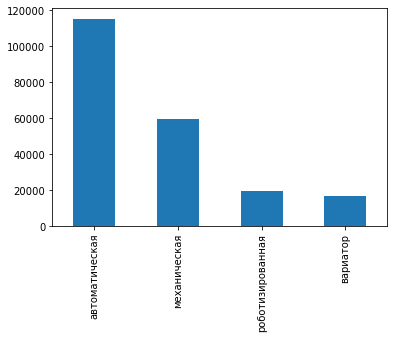

In [59]:
data['vehicleTransmission'] = data['vehicleTransmission'].astype('category')
data['vehicleTransmission'].value_counts().plot.bar()


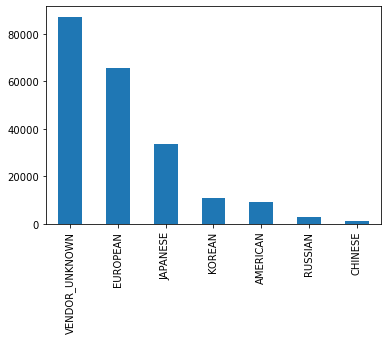

In [60]:
data['vendor'] = data['vendor'].fillna('VENDOR_UNKNOWN')
data['vendor'].value_counts().plot.bar()
data['vendor'] = data['vendor'].astype('category')

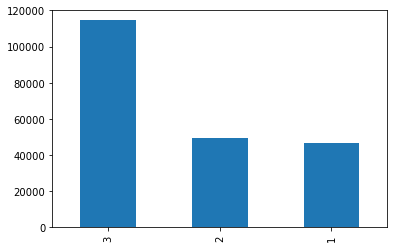

In [61]:
data['Владельцы'] = data['Владельцы'].fillna(data['Владельцы'].describe().top)
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(re.findall('\d', str(x))[0]))
data['Владельцы'] = data['Владельцы'].astype('category')
data['Владельцы'].value_counts().plot(kind='bar')

In [62]:
data['ПТС'].value_counts()

ORIGINAL     143952
Оригинал      40697
DUPLICATE     18445
Дубликат       6750
Name: ПТС, dtype: int64

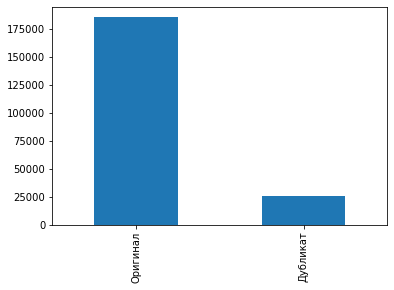

In [63]:
pts = {'ORIGINAL':    'Оригинал',     'DUPLICATE':     'Дубликат'}       
data['ПТС'] = data['ПТС'].replace(pts)
data['ПТС'] = data['ПТС'].fillna(data['ПТС'].describe().top)
data['ПТС'].value_counts().plot(kind='bar')


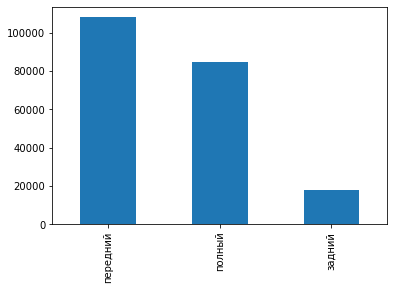

In [64]:
data['Привод'] = data['Привод'].astype('category')
data['Привод'].value_counts().plot(kind='bar')

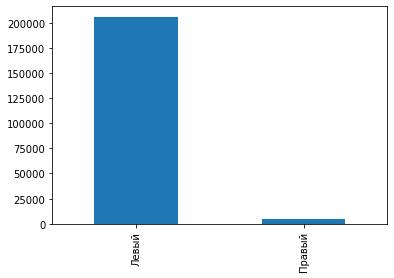

In [65]:
rule={
    'LEFT':      
'Левый',      
'RIGHT':       
'Правый'      
}
data['Руль'] = data['Руль'].replace(rule)
data['Руль'].value_counts().plot.bar()

In [66]:
data['price'] = data['price'].fillna(0).astype('int')


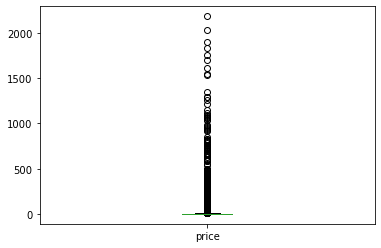

In [67]:
data[data['sample'] == 1]['price'].value_counts().plot.box()

In [68]:
data = data.drop(['model'], axis=1)

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210652 entries, 0 to 14646
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   bodyType             210652 non-null  category
 1   brand                210652 non-null  category
 2   color                210652 non-null  category
 3   engineDisplacement   210652 non-null  object  
 4   enginePower          210652 non-null  int32   
 5   fuelType             210652 non-null  category
 6   mileage              210652 non-null  float64 
 7   model_name           210652 non-null  object  
 8   numberOfDoors        210652 non-null  float64 
 9   productionDate       210652 non-null  float64 
 10  vehicleTransmission  210652 non-null  category
 11  vendor               210652 non-null  category
 12  Владельцы            210652 non-null  category
 13  ПТС                  210652 non-null  object  
 14  Привод               210652 non-null  category
 15  Р

In [70]:
data.corr()

,enginePower,mileage,numberOfDoors,productionDate,price,sample,log_price
enginePower,1.000000,-0.176019,0.014233,0.205255,0.493914,-0.067567,0.620755
mileage,-0.176019,1.000000,-0.099248,-0.726091,-0.437871,-0.100523,-0.644073
numberOfDoors,0.014233,-0.099248,1.000000,0.196759,0.074473,0.037445,0.145720
productionDate,0.205255,-0.726091,0.196759,1.000000,0.426463,0.087736,0.726725
price,0.493914,-0.437871,0.074473,0.426463,1.000000,0.250988,0.756016
sample,-0.067567,-0.100523,0.037445,0.087736,0.250988,1.000000,NaN
log_price,0.620755,-0.644073,0.145720,0.726725,0.756016,NaN,1.000000


productionDate - имеет высокую корреляцию с mileage, по этому мы удаляем этот столбец

In [71]:
data = data.drop(['productionDate'], axis=1)

In [72]:
for colum in ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_name', 'vehicleTransmission', 'vendor', 'Владельцы', 'Привод','ПТС','Руль']:
    data[colum] = data[colum].astype('category').cat.codes

In [73]:
data

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,price,sample,log_price
0,4,12,14,30,105,0,74000.0,777,5.0,3,2,2,1,1,0,0,0,-inf
1,4,12,17,7,110,0,60563.0,777,5.0,2,2,0,1,1,0,0,0,-inf
2,4,12,13,10,152,0,88000.0,1039,5.0,3,2,0,1,1,0,0,0,-inf
3,4,12,7,7,110,0,95000.0,777,5.0,0,2,0,1,1,0,0,0,-inf
4,4,12,1,10,152,0,58536.0,777,5.0,0,2,0,1,1,0,0,0,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14642,0,10,0,30,128,0,99000.0,812,5.0,2,5,1,1,2,0,400000,1,12.899220
14643,9,10,17,7,117,0,156640.0,692,5.0,2,1,2,1,1,0,210000,1,12.254863
14644,7,10,5,7,81,0,50089.0,36,4.0,2,5,2,0,1,0,199000,1,12.201060
14645,7,10,13,7,74,0,50000.0,30,4.0,2,5,1,1,0,0,120000,1,11.695247


In [74]:
X = data.query('sample == 1').drop(['sample'], axis=1)
X = X[X['price'] != 0]  

In [75]:
y = X['price']
X = X.drop(['price'], axis=1)
X_sub = data.query('sample == 0').drop(['sample'], axis=1)

In [94]:
X_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  int8   
 1   brand                34686 non-null  int8   
 2   color                34686 non-null  int8   
 3   engineDisplacement   34686 non-null  int8   
 4   enginePower          34686 non-null  int32  
 5   fuelType             34686 non-null  int8   
 6   mileage              34686 non-null  float64
 7   model_name           34686 non-null  int16  
 8   numberOfDoors        34686 non-null  float64
 9   vehicleTransmission  34686 non-null  int8   
 10  vendor               34686 non-null  int8   
 11  Владельцы            34686 non-null  int8   
 12  ПТС                  34686 non-null  int8   
 13  Привод               34686 non-null  int8   
 14  Руль                 34686 non-null  int8   
 15  price                34686 non-null 

In [76]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175250 entries, 0 to 14646
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             175250 non-null  int8   
 1   brand                175250 non-null  int8   
 2   color                175250 non-null  int8   
 3   engineDisplacement   175250 non-null  int8   
 4   enginePower          175250 non-null  int32  
 5   fuelType             175250 non-null  int8   
 6   mileage              175250 non-null  float64
 7   model_name           175250 non-null  int16  
 8   numberOfDoors        175250 non-null  float64
 9   vehicleTransmission  175250 non-null  int8   
 10  vendor               175250 non-null  int8   
 11  Владельцы            175250 non-null  int8   
 12  ПТС                  175250 non-null  int8   
 13  Привод               175250 non-null  int8   
 14  Руль                 175250 non-null  int8   
 15  log_price         

## Train Split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, random_state=RANDOM_SEED)

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.




In [78]:
tmp_train = X_train.copy()



In [79]:
tmp_train.head()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,model_name,numberOfDoors,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,log_price
9712,0,1,13,23,340,0,1000.0,1194,5.0,0,2,2,1,2,0,16.073224
41122,0,10,16,15,238,0,132472.0,363,5.0,0,6,2,1,2,0,13.507626
3236,0,0,12,30,211,2,95000.0,857,5.0,0,6,1,1,2,0,14.038654
80338,0,10,12,30,299,0,233000.0,887,5.0,0,6,2,0,2,0,13.180632
2166,7,0,16,11,180,0,99900.0,123,4.0,1,6,2,1,1,0,13.864301


In [80]:
y_train.head()

9712     9561200
41122     735000
3236     1250000
80338     530000
2166     1050000
Name: price, dtype: int32

In [81]:
tmp_train['price'] = y_train

In [82]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 96.70%


# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Fit

### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [84]:
np.log(y_train)

9712     16.073224
41122    13.507626
3236     14.038654
80338    13.180632
2166     13.864301
           ...    
33843    13.763164
17258    12.254863
46120    16.077065
61405    13.440090
35955    12.206073
Name: price, Length: 122675, dtype: float64

In [85]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')

In [86]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))

In [87]:
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 0.49%


Точность модели по метрике MAPE: 17.32%

Как видим точность возросла до 15%, а что будет на ЛБ?

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

estimators = [
    ('cb',model),
    ('rf',RandomForestRegressor(random_state=RANDOM_SEED))
]

reg = StackingRegressor(estimators=estimators)
reg.fit(X_train, np.log(y_train))

predict_test = np.exp(reg.predict(X_test))


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [90]:
predict_submission = np.exp(reg.predict(X_sub))

print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
gb.fit(X_train, np.log(y_train))
predict_test = np.exp(gb.predict(X_test))


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [120]:
X_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  int8   
 1   brand                34686 non-null  int8   
 2   color                34686 non-null  int8   
 3   engineDisplacement   34686 non-null  int8   
 4   enginePower          34686 non-null  int32  
 5   fuelType             34686 non-null  int8   
 6   mileage              34686 non-null  float64
 7   model_name           34686 non-null  int16  
 8   numberOfDoors        34686 non-null  float64
 9   vehicleTransmission  34686 non-null  int8   
 10  vendor               34686 non-null  int8   
 11  Владельцы            34686 non-null  int8   
 12  ПТС                  34686 non-null  int8   
 13  Привод               34686 non-null  int8   
 14  Руль                 34686 non-null  int8   
 15  price                34686 non-null 

In [91]:
predict_submission = np.exp(gb.predict(X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [92]:
model = CatBoostRegressor(iterations = 10000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          use_best_model=True,
                          
                         )
model.fit(X_train, np.log(y_train),
         #cat_features=cat_features_ids,
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_2_baseline.model')
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(X_sub))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 0.49%


In [115]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeRegressor
gbc = DecisionTreeRegressor(random_state=RANDOM_SEED)
gbc.fit(X_train, np.log(y_train))
predict_test = np.exp(gbc.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

Точность модели по метрике MAPE: 0.00%


In [116]:
a = pd.DataFrame(gbc.feature_importances_)
a['name'] = X_train.columns.values
a.sort_values(by=0)

,0,name
14,5.095240e-12,Руль
12,4.134616e-11,ПТС
13,6.009742e-11,Привод
11,1.018490e-10,Владельцы
5,4.900858e-10,fuelType
1,4.980557e-10,brand
0,7.011458e-10,bodyType
8,7.799729e-10,numberOfDoors
10,2.486385e-09,vendor
7,1.053585e-08,model_name


In [117]:
gbc.get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [118]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_features':['auto', 'sqrt', 'log2', 'None'], 
             'max_depth': [5,6,7,8,9,10,11,12,13,14,15]
             }
clf = GridSearchCV(estimator = gbc, param_grid = param_grid, scoring='accuracy', n_jobs=-1, cv=5)
clf.fit(X_train, np.log(y_train))
predict_test = np.exp(clf.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test))*100:0.2f}%")

ValueError: continuous is not supported

In [ ]:
clf.best_params_

In [ ]:
clf.best_score_

# Submission

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

В итоге получили **MAPE 27%** на ЛБ!

Большая разница в ошибке может указывать на то что тест и трейн имеют различия по выборке или то что данные в трейне могли уже устареть и их нужно обновлять.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing